In [14]:
import sys
sys.path.append('src/')
import numpy as np
import matplotlib.pyplot as plt
import coordinates as coord
import spiceypy as spice
metakernel_path = "SPICE/metakernel_eclipse.txt"
spice.furnsh(metakernel_path)

#### Constants

In [15]:
pi      = np.pi
deg2rad = pi / 180.0
rad2deg = 180.0 / pi

min2rad = deg2rad / 60.0
rad2min = rad2deg * 60.0

sec2rad = min2rad / 60.0
rad2sec = rad2min * 60.0

a_ell = 6378137.0
c_ell = 6356752.314245
e_ell = np.sqrt(1 - c_ell ** 2  / a_ell ** 2)

R_sun  = 696000000.0
R_moon = 1737000.0



### Question 1
When multiplying the rotations, you go from the right (first rotation) to the left (last rotation). Thus, from left to right, you will rotate about the X-axis, about the Y-axis, and then about the Z-axis. The sequence of rotations can be applied as:

$
\begin{bmatrix}
1 & 0 & 0 \\
0 & \cos(\alpha) & \sin(\alpha) \\
0 & -\sin(\alpha) & \cos(\alpha)
\end{bmatrix}
\begin{bmatrix}
\cos(\beta) & 0 & -\sin(\beta) \\
0 & 1 & 0 \\
\sin(\beta) & 0 & \cos(\beta)
\end{bmatrix}
\begin{bmatrix}
\cos(\gamma) & \sin(\gamma) & 0 \\
-\sin(\gamma) & \cos(\gamma) & 0 \\
0 & 0 & 1
\end{bmatrix}
$


Multiplying this out, we get:
$
\begin{bmatrix}
    \cos(\beta)\cos(\gamma) & \cos(\beta)\sin(\gamma) & -\sin(\beta) \\
    \cos(\gamma)\sin(\alpha)\sin(\beta) - \cos(\alpha)\sin(\gamma) & \cos(\alpha)\cos(\gamma) + \sin(\alpha)\sin(\beta)\sin(\gamma) & \cos(\beta)\sin(\alpha) \\
    \sin(\alpha)\sin(\gamma) + \cos(\alpha)\cos(\gamma)\sin(\beta) & \cos(\alpha)\sin(\beta)\sin(\gamma) - \cos(\gamma)\sin(\alpha) & \cos(\alpha)\cos(\beta)
\end{bmatrix}
$

### Question 2

#### 2a)

We first make a function that will convert from degree, minute, second to a decimal number.

In [16]:
def dms_to_dd(d, m, s):
    if d < 0:
        dd = float(d) - float(m)/60 - float(s)/3600
    else:
        dd = float(d) + float(m)/60 + float(s)/3600
    return dd

Then, we convert the Durand Building geodetic coordinates to decimal values and use coord.BLH2XYZ() to convert to ECEF coordinates.

In [17]:
B_Durand = dms_to_dd(37, 25, 37.72) * deg2rad
L_Durand = dms_to_dd(-122, 10, 26.01) * deg2rad
H_Durand = 35
(x_ecef_Durand, y_ecef_Durand, z_ecef_Durand) = coord.BLH2XYZ(B_Durand, L_Durand, H_Durand, a_ell, e_ell)

print(B_Durand,L_Durand,H_Durand)
print(x_ecef_Durand,y_ecef_Durand,z_ecef_Durand)


0.6532269001750595 -2.132336669558196 35
-2700446.8349183095 -4292573.444621282 3855167.2091753073


#### 2b)

The center of the Earth is at point (0,0,0) in the ECEF frame, so the distance between the center of the Earth and Durand is just:

$$\sqrt{x_{Durand}^2+y_{Durand}^2+z_{Durand}^2}$$

In [18]:
print(np.sqrt( x_ecef_Durand**2 + y_ecef_Durand**2 + z_ecef_Durand**2))

6370315.070417526


#### 2c)

The elevation in the East-North-Up coordinate system is the angle above the East-North plane. Thus, it is equal to:
$$\text{atan2}\left( z_{ENU}, \sqrt{x_{ENU}^2 + y_{ENU}^2} \right)$$

In [19]:
def elevation(x_neu, y_neu, z_neu):
    return np.arctan2(z_neu, np.sqrt(x_neu**2 + y_neu**2))

The latitude, longitude, and elevation of the Campanile and Hoover Tower are found from Google and then converted to the ECEF frame. Then, the coordinate of the Campanile are transformed to the ENU coordinate frame with Hoover Tower as the reference location. Then, the elevation is computed using the function defined directly above.

In [20]:
B_Campanile = 37.87198097427293 * deg2rad
L_Campanile = -122.25780722111945 * deg2rad
H_Campanile = 94 + 96
(x_ecef_Campanile, y_ecef_Campanile, z_ecef_Campanile) = coord.BLH2XYZ(B_Campanile, L_Campanile, H_Campanile, a_ell, e_ell)

B_Hoover = 37.42753762534559 * deg2rad
L_Hoover = -122.16697625074472 * deg2rad
H_Hoover = 86.868 + 24
(x_ecef_Hoover, y_ecef_Hoover, z_ecef_Hoover) = coord.BLH2XYZ(B_Hoover, L_Hoover, H_Hoover, a_ell, e_ell)

(x_neu_hoover_to_campanile,y_neu_hoover_to_campanile,z_neu_hoover_to_campanile) = \
    coord.XYZ2NEU(x_ecef_Campanile,y_ecef_Campanile,z_ecef_Campanile,x_ecef_Hoover,y_ecef_Hoover,z_ecef_Hoover,a_ell,e_ell)
print(x_neu_hoover_to_campanile,y_neu_hoover_to_campanile,z_neu_hoover_to_campanile)

el_campanile_from_hoover = elevation(x_neu_hoover_to_campanile, y_neu_hoover_to_campanile, z_neu_hoover_to_campanile)
print(el_campanile_from_hoover * rad2deg)

49333.53469014472 -7991.990833070045 -117.22719248084832
-0.13439487547696655


### Question 3

We start by reading the data from the ISS coordinate text file and organizing into arrays of time, X, Y, and Z. We then convert these coordinates to the ENU frame with Durand as the reference location. Like we did in 2c, we use the elevation function to calculate the an array of the ISS elevation as a function of time.

In [21]:
iss_data = np.loadtxt("data/ISS_coords.txt")
time = iss_data[:,0]
x_ecef_iss = iss_data[:,1]
y_ecef_iss = iss_data[:,2]
z_ecef_iss = iss_data[:,3]

(x_neu_durand_to_iss,y_neu_durand_to_iss,z_neu_durand_to_iss) = \
        coord.XYZ2NEU(x_ecef_iss,y_ecef_iss,z_ecef_iss,x_ecef_Durand,y_ecef_Durand,z_ecef_Durand,a_ell,e_ell)
print(x_ecef_Durand)
el_iss_from_durand = elevation(x_neu_durand_to_iss, y_neu_durand_to_iss, z_neu_durand_to_iss)

-2700446.8349183095


Now, we plot this elevation vs. the tabulated time.

Text(0, 0.5, 'Elevation [deg]')

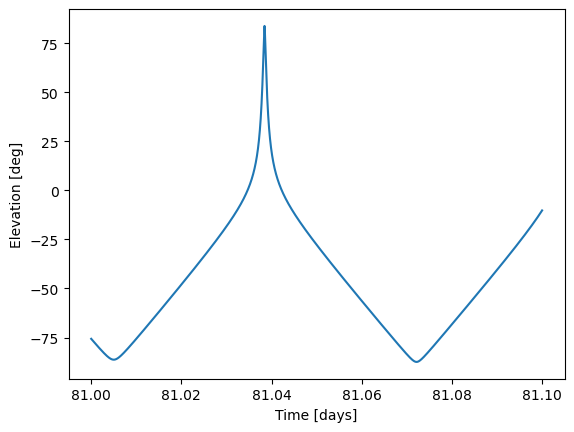

In [22]:
plt.figure()
plt.plot(time,np.array(el_iss_from_durand) * rad2deg)
plt.xlabel("Time [days]")
plt.ylabel("Elevation [deg]")

### 3a)


The maximum elevation is the maximum value in the elevation array. This value is in radians, and we convert to degrees.

In [23]:
print(max(el_iss_from_durand) * rad2deg)

83.91937939874983


### 3b)

From the viewpoint of Durand, the ISS is in the sky when its elevation is greater than 0. To find the time it takes to cross the sky, we find the difference between the two times where the elevation is equal to zero. This is given in days, so we multiply by 86400 to get to seconds.

In [24]:
indices_above_horizon = [(el > 0) for el in el_iss_from_durand]
times_above_horizon = time[indices_above_horizon]
print((times_above_horizon[-1] - times_above_horizon[0])*86400)

656.9921699207498


#### 3c)
If you convert to Pacific time, you find that the ISS elevation is greater than 0 during the afternoon. Since this is during the day, we can assume that the ISS is not visible. If this was a lower elevation pass during the night, one may also need to consider if there is any infrasructure blocking the view.

### Question 4

Define the orbit parameters.

In [25]:
e_moon = 0.055
a_moon = 384000     # km
radius_moon = 1740  # km
e_earth = 0.017
a_earth = 149600000 # km
radius_earth = 6378 # km
radius_sun = 696000 # km

#### 4a)

The maximum possible total eclipse magnitude will occur when the moon is closest to the Earth while the Sun is farthest from the Earth.

We calculate the approximate angular size of the moon and the Sun at these locations, and the eclipse magnitude will be the ratio of these angular sizes.

In [26]:
dist_earthmoon_min = a_moon * (1 - e_moon)
ang_moon_max = 2 * radius_moon / dist_earthmoon_min # max angle swept by moon in the sky
dist_earthsun_max = a_earth * (1 + e_earth)
ang_sun_min = 2 * radius_sun / dist_earthsun_max # min angle swept by sun in the sky
eclipse_magnitude_max = ang_moon_max / ang_sun_min
print(eclipse_magnitude_max)

1.0481646825396824


#### 4b)

The minimum possible annular eclipse magnitude will occur when the moon is farthest from the Earth while the Sun is closest to the Earth.

We calculate the approximate angular size of the moon and the Sun at these locations, and the eclipse magnitude will be the ratio of these angular sizes.

In [27]:
dist_earthmoon_max = a_moon * (1 + e_moon)
ang_moon_min = 2 * radius_moon / dist_earthmoon_max # min angle swept by moon in the sky
dist_earthsun_min = a_earth * (1 - e_earth)
ang_sun_max = 2 * radius_sun / dist_earthsun_min # max angle swept by sun in the sky
eclipse_magnitude_min = ang_moon_min / ang_sun_max
print(eclipse_magnitude_min)

0.9074891390205371


#### 4c)

Similarly, the maximum possible solar eclipse magnitude observed from the moon will occur when the Earth is closest to the moon while the Sun is farthest from the moon.

We calculate the approximate angular size of the Earth and the Sun at these locations, and the eclipse magnitude will be the ratio of these angular sizes.

In [28]:
dist_earthmoon_min = a_moon * (1 - e_moon)
ang_earth_max = 2 * radius_earth / dist_earthmoon_min   # max angle swept by Earth in the sky
dist_earthsun_max = a_earth * (1 + e_earth)
dis_moonsun_max = dist_earthsun_max + a_moon
ang_sun_min = 2 * radius_sun / dis_moonsun_max          # min angle swept by sun in the sky
eclipse_magnitude_min = ang_earth_max / ang_sun_min
print(eclipse_magnitude_min)

3.8517628512132815


#### 4d) 
Compute the duration of an eclipse in Austin, Texas. We copy the code from "lecture3_eclipse.ipynb" but look only at the latitude and longitude of Austin.

We compute the positions of the sun and moon during the times of the April 8 eclipse, and we compute the location of the shadow cast on the Earth.

In [29]:
B_austin = 30.2672  * deg2rad
L_austin = -97.7431 * deg2rad
H_austin = 150.0
n_steps  = 10000
t_start  = '2024 APR 08 16:17:22.0000'
t_end    = '2024 APR 08 20:17:22.0000'
et_start = spice.str2et(t_start)
et_end   = spice.str2et(t_end)
times    = np.linspace(et_start, et_end, n_steps)

state_sun  = np.zeros((6, len(times)))
state_moon = np.zeros((6, len(times)))

x_austin, y_austin, z_austin = coord.BLH2XYZ(B_austin, L_austin, H_austin, a_ell, e_ell)

#Run spkpos as a vectorized function
for i in range(len(times)):
    state_sun[:,i], _  = spice.spkez(10, times[i], 'ITRF93', "LT+S", 399)
    state_moon[:,i], _ = spice.spkez(301, times[i], 'ITRF93', "LT+S", 399)

state_sun  = state_sun * 1e3
state_moon = state_moon * 1e3

r_MS = np.sqrt((state_sun[0,:] - state_moon[0,:]) ** 2 +\
               (state_sun[1,:] - state_moon[1,:]) ** 2 +
               (state_sun[2,:] - state_moon[2,:]) ** 2)

d_shadow = (R_moon * r_MS) / (R_sun - R_moon)

pos_shadow_tip = state_moon[0:3,:] + (state_moon[0:3,:] - state_sun[0:3,:]) / r_MS * d_shadow

Define a function that returns whether a location is in the shadow cone.

In [30]:
def is_in_cone(p, cone_tip,cone_dir,cone_height,cone_base_radius):
    cone_dist = np.dot(p - cone_tip, cone_dir)
    if (0.0 < cone_dist) and (cone_dist < cone_height):
        cone_radius   = cone_dist / cone_height * cone_base_radius
        orth = p - cone_tip - cone_dist * cone_dir
        orth_distance = np.sqrt(orth[0] ** 2 + orth[1] ** 2 + orth[2] ** 2)
        if orth_distance < cone_radius:
            return 1
        else:
            return 0
    else:
        return 0

Check if Austin is in the shadow cone for each time during the eclipse.

In [31]:
is_in_eclipse = np.zeros(times.shape)

for k in range(len(times)):

    h        = d_shadow[k]
    x        = pos_shadow_tip[:,k]
    v        = (state_moon[0:3,k] - x) / h
    h        = d_shadow[k]

    p = np.array([x_austin,y_austin,z_austin])
    is_in_eclipse[k] = is_in_cone(p, x, v, h, R_moon)

Now, we plot when Austin is in the shadow (value of 1).

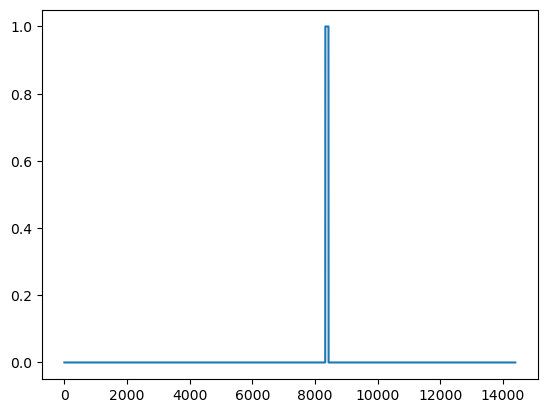

In [32]:
plt.plot(times - times[0],is_in_eclipse)

The number of seconds when Austin is completely in shadow can be calculated as the times when the value is equal to 1.

In [33]:
print(times[is_in_eclipse == 1.0][-1] - times[is_in_eclipse == 1.0][0])
print(times[is_in_eclipse == 1.0][-1] - times[0])
print(times[is_in_eclipse == 1.0][0] - times[0])

102.25022494792938
8433.48334801197
8331.233123064041


### Question 5

#### 5a)

We start by converting the coordinates of Vandenberg Air Force Base to the ECEF frame. Then, we find the coordinates of Vandenberg Air Force Base in the ENU frame with reference to the Durand Building.

In [43]:
B_Vandy = dms_to_dd(34, 45, 20.09) * deg2rad
L_Vandy = dms_to_dd(-120, 37, 20.91) * deg2rad
H_Vandy = 56
(x_ecef_Vandy, y_ecef_Vandy, z_ecef_Vandy) = coord.BLH2XYZ(B_Vandy, L_Vandy, H_Vandy, a_ell, e_ell)
(x_neu_durand_to_vandy,y_neu_durand_to_vandy,z_neu_durand_to_vandy) = \
    coord.XYZ2NEU(x_ecef_Vandy,y_ecef_Vandy,z_ecef_Vandy,x_ecef_Durand,y_ecef_Durand,z_ecef_Durand,a_ell,e_ell)
print(y_ecef_Vandy)
print(x_neu_durand_to_vandy,y_neu_durand_to_vandy,z_neu_durand_to_vandy)

-4514386.081865029
-295165.26004447823 142029.72087982768 -8415.520173436496


Define a function that calculates the azimuth (angle east of north).

In [35]:
def azimuth(x_neu,y_neu):
    return np.arctan2(y_neu,x_neu)

Now, calculate the azimuth and elevation of Vandenberg Air Force Base and convert to degrees.

In [45]:
az_durand_to_vandy = azimuth(x_neu_durand_to_vandy, y_neu_durand_to_vandy)
el_durand_to_vandy = elevation(x_neu_durand_to_vandy, y_neu_durand_to_vandy, z_neu_durand_to_vandy)
print(az_durand_to_vandy * rad2deg, el_durand_to_vandy * rad2deg)

154.3037394961327 -1.4716969362085683


#### 5b)

We will now have a rocket starting at the Vandenberg Air Force Base and travelling straight up. This means only the height will change (latitude and longitude stay constant). We convert the coordinates of the rocket to the ENU frame with Durand as the reference point and then calculate the elevation at each rocket height.

In [37]:
heights = np.linspace(0,20000,20000)
(x_ecef_Vandy_curr, y_ecef_Vandy_curr, z_ecef_Vandy_curr) = coord.BLH2XYZ(B_Vandy, L_Vandy, heights, a_ell, e_ell)
(x_neu_durand_to_vandy_curr,y_neu_durand_to_vandy_curr,z_neu_durand_to_vandy_curr) = \
    coord.XYZ2NEU(x_ecef_Vandy_curr,y_ecef_Vandy_curr,z_ecef_Vandy_curr,x_ecef_Durand,y_ecef_Durand,z_ecef_Durand,a_ell,e_ell)

els_durand_to_vandy = elevation(x_neu_durand_to_vandy_curr, y_neu_durand_to_vandy_curr, z_neu_durand_to_vandy_curr)

Now, we plot the elevation of the rocket as a function of its height.

Text(0, 0.5, 'Elevation [deg]')

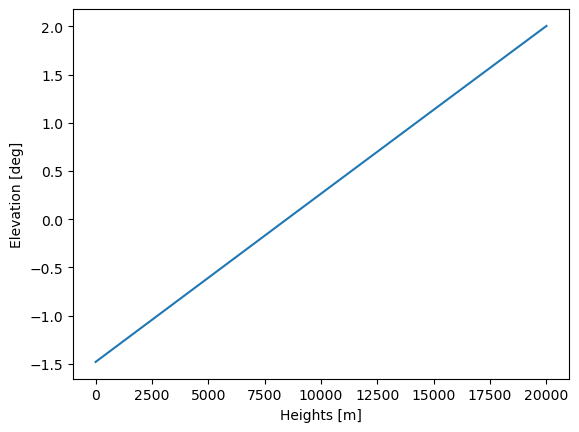

In [38]:
plt.figure()
plt.plot(heights, np.array(els_durand_to_vandy) * rad2deg)
plt.xlabel("Heights [m]")
plt.ylabel("Elevation [deg]")

We find the height where the elevation crosses from negative to positive (crosses the horizon).

In [39]:
index_rocket_visible = [(el > 0) for el in els_durand_to_vandy]
els_rocket_visible = np.array(els_durand_to_vandy)[index_rocket_visible]
print(np.array(heights)[index_rocket_visible][0])

8483.42417120856


### 5c)
Likely not. There is significant building obstruction in the direction of Vandenburg from the 4th floor of Durand, which will prevent us from seeing the low elevation flight of any rockets. Waiting for the launches to gain altitude would not help much either, as the rockets would likely perform their gravity turns prior to reaching a sufficient elevation angle for visibility.

#### 5d)
The dish might be a good location! You have a fair amount of altitude here, and don't have any obstrucution from Stanford buildings. This will all help in minimizng the elevation angle at which you have line of sight to Vandeburg, increasing chance of visibility.